# Load cubiomes data

In [ ]:
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from dataclasses import asdict
from typing import Literal
import json
import random

from data import World


def convert_cubiome_to_csv(cubiome_export_path, type: Literal["biomes", "structures"]):
    df = pd.read_csv(
        cubiome_export_path,
        header=6 if type == "biomes" else 5,
        sep=";",
    )

    return df


In [13]:
biomes = convert_cubiome_to_csv("biomes.txt", type="biomes")
structures = convert_cubiome_to_csv("structures.txt", type="structures")

In [3]:
ALL_BIOMES = biomes.columns[1:]
ALL_STRUCTURES = structures.structure.unique()
ALL_SEEDS = structures.seed.unique()

# Convert DataFrame representation to something easier to work with 

In [14]:
worlds = []

for seed in tqdm(ALL_SEEDS):
    world = World(seed)
    subs_structs = structures[structures["seed"] == seed]
    subs_biomes = biomes[biomes["seed"] == seed]

    for kind, count in subs_biomes.T.iloc[2:, :].itertuples():
        world.add_biome(kind, count)

    for _, _, kind, x, z, details in subs_structs.itertuples():
        world.add_structure(kind, x, z, details)

    worlds.append(world)

del biomes, structures

100%|██████████| 881/881 [00:26<00:00, 32.66it/s]


# Showcase

In [5]:
idx = random.randint(0, len(worlds))
world = worlds[idx]

## Visualise Spawn

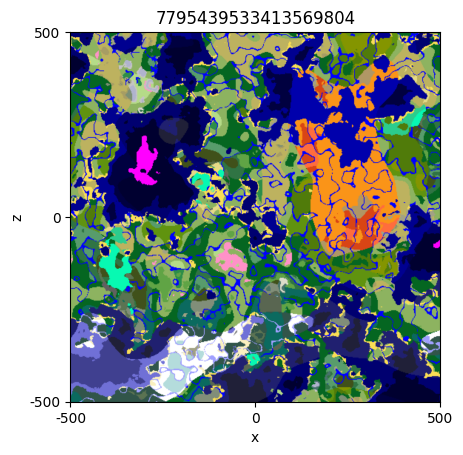

In [6]:
img = world.generate_image()

plt.title(world.seed)
plt.imshow(img)
plt.xticks([0, 1000, 2000], [-500, 0, 500])
plt.xlabel("x")
plt.yticks([0, 1000, 2000], [500, 0, -500])
plt.ylabel("z")
plt.show()

## Get count of each structure or biome

In [7]:
df = dict(Counter([structure.kind for structure in world.structures]).most_common())
pd.DataFrame(
    data={"kind": [str(k) for k in df.keys()], "count": [c for c in df.values()]}
)

,kind,count
0,amethyst_geode,16275
1,mineshaft,1643
2,trial_chambers,327
3,ocean_ruin,258
4,ruined_portal,246
5,shipwreck,206
6,buried_treasure,112
7,village,76
8,trail_ruins,40
9,igloo,29


In [8]:
pd.DataFrame(world.biomes).sort_values("count", ascending=False)

,kind,count
14,forest,43718
30,plains,42122
31,river,24336
32,savanna,21407
15,frozen_ocean,21201
43,taiga,18539
5,cold_ocean,18113
37,snowy_taiga,17249
26,ocean,16128
22,lukewarm_ocean,15405


## Serialise or deserialise world information

In [ ]:
with open("worlds.json", "w") as file:
    json.dump([asdict(world) for world in worlds], file)

In [ ]:
with open("worlds.json", "r") as file:
    raw_data = json.load(file)
    worlds = [World.from_dict(world_json) for world_json in raw_data]